In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import EMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
from collections import Counter
import torchvision.transforms.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [10]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: F.rotate(x, -90)),  
    transforms.Lambda(lambda x: F.hflip(x)),       
    transforms.Normalize((0.5,), (0.5,))
])

emnist_train = EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)

emnist_test = EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)
emnist_mapping = emnist_train.classes

100%|███████████████████████████████████████████████████████████████████████████████| 562M/562M [00:48<00:00, 11.6MB/s]


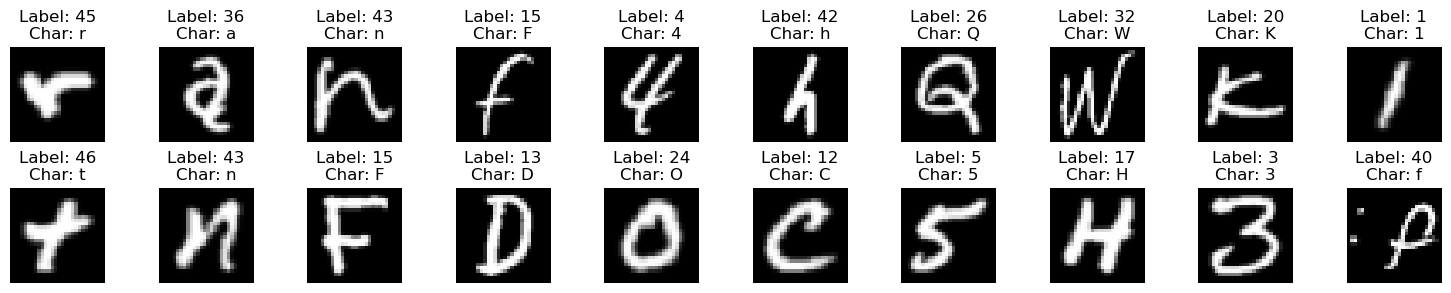

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def show_samples(dataset, mapping, n=20):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        image, label = dataset[i]
        image = image.squeeze().numpy()
        char = mapping[label]        
        plt.subplot(2, n//2, i+1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label}\nChar: {char}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
show_samples(emnist_train, emnist_mapping)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(42)
np.random.seed(42)


# Model Architecture 
class EMNIST_CNN(nn.Module):
    def __init__(self, num_classes=47):
        super().__init__()
        self.conv_layers = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Conv Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Conv Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 3 * 3, 256),  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  
        x = self.fc_layers(x)
        return x

In [14]:
batch_size = 64
learning_rate = 0.001
num_epochs = 20

In [18]:
train_loader = DataLoader(emnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(emnist_test, batch_size=batch_size, shuffle=False)

In [20]:
model = EMNIST_CNN(num_classes=len(emnist_mapping)).to(device)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

In [24]:
def train_model():
    train_loss_history = []
    val_loss_history = []
    accuracy_history = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        
        epoch_loss = running_loss / len(train_loader)
        train_loss_history.append(epoch_loss)
        
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(test_loader)
        val_loss_history.append(val_loss)
        accuracy = 100 * correct / total
        accuracy_history.append(accuracy)
        
        scheduler.step(val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Accuracy: {accuracy:.2f}%')
    
    return train_loss_history, val_loss_history, accuracy_history


In [26]:
train_loss, val_loss, accuracy = train_model()

Epoch [1/20], Train Loss: 0.8577, Val Loss: 0.4205, Accuracy: 84.86%
Epoch [2/20], Train Loss: 0.5192, Val Loss: 0.3745, Accuracy: 86.85%
Epoch [3/20], Train Loss: 0.4561, Val Loss: 0.3535, Accuracy: 87.61%
Epoch [4/20], Train Loss: 0.4230, Val Loss: 0.3578, Accuracy: 86.82%
Epoch [5/20], Train Loss: 0.3932, Val Loss: 0.3370, Accuracy: 87.65%
Epoch [6/20], Train Loss: 0.3738, Val Loss: 0.3363, Accuracy: 88.21%
Epoch [7/20], Train Loss: 0.3515, Val Loss: 0.3344, Accuracy: 88.32%
Epoch [8/20], Train Loss: 0.3348, Val Loss: 0.3272, Accuracy: 88.39%
Epoch [9/20], Train Loss: 0.3201, Val Loss: 0.3221, Accuracy: 88.89%
Epoch [10/20], Train Loss: 0.3047, Val Loss: 0.3287, Accuracy: 88.64%
Epoch [11/20], Train Loss: 0.2947, Val Loss: 0.3232, Accuracy: 89.09%
Epoch [12/20], Train Loss: 0.2840, Val Loss: 0.3261, Accuracy: 88.95%
Epoch [13/20], Train Loss: 0.2383, Val Loss: 0.3214, Accuracy: 89.47%
Epoch [14/20], Train Loss: 0.2260, Val Loss: 0.3221, Accuracy: 89.41%
Epoch [15/20], Train Loss: 0.

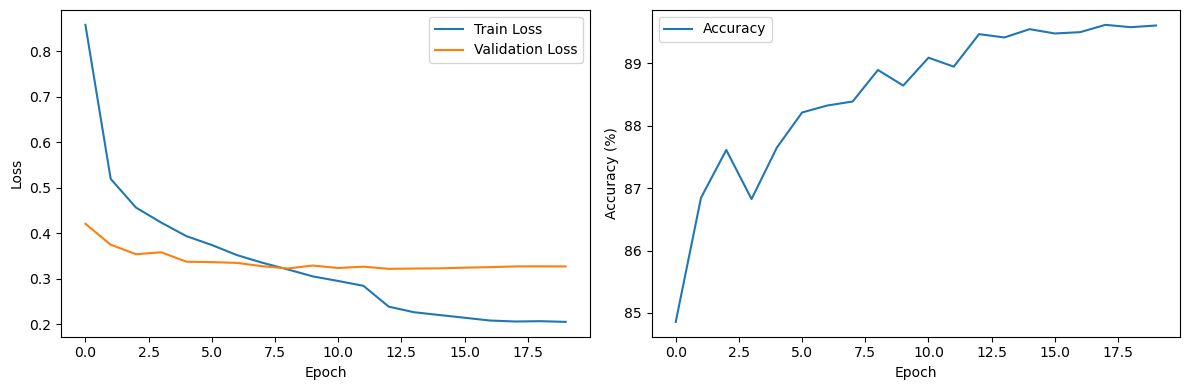

In [27]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
# Save both the model and class mapping
torch.save({
    'model_state_dict': model.state_dict(),
    'class_mapping': emnist_mapping,
    'input_size': (1, 28, 28)  
}, 'cnn_model.pth')

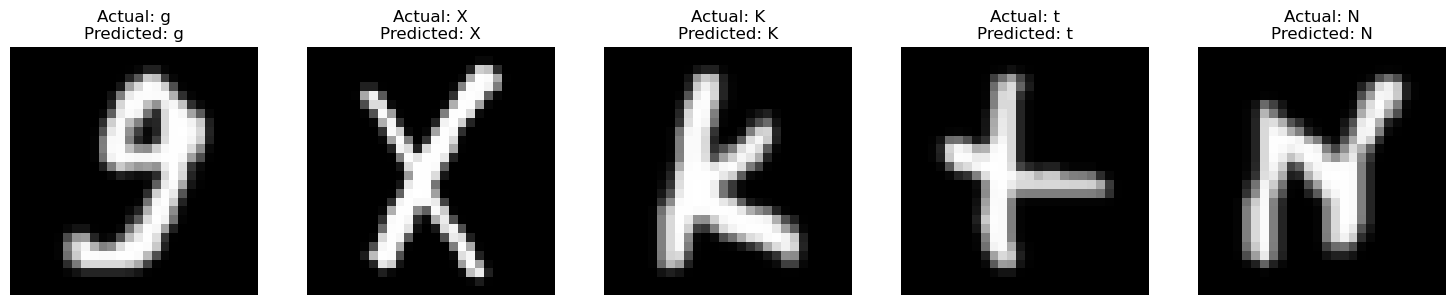

In [36]:
import torch
import matplotlib.pyplot as plt

# Manually test a few samples from the test dataset
def test_samples(model, test_loader, mapping, num_samples=5):
    model.eval()
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))  # Create a row of subplots

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            if i >= num_samples:
                break
            images = images.to(device)
            labels = labels.to(device)

            # Make prediction
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            # Convert image to numpy for plotting
            image = images[0].cpu().squeeze().numpy()
            actual_label = labels[0].item()
            predicted_label = predicted[0].item()
            char = mapping[actual_label]
            predicted_char = mapping[predicted_label]

            # Plot image and prediction
            ax = axes[i]  # Get the axis for the current subplot
            ax.imshow(image, cmap='gray')
            ax.set_title(f"Actual: {char}\nPredicted: {predicted_char}")
            ax.axis('off')

    plt.tight_layout()  # Adjust layout to avoid overlapping
    plt.show()

# Test and show 5 random samples
test_samples(model, test_loader, emnist_mapping, num_samples=5)

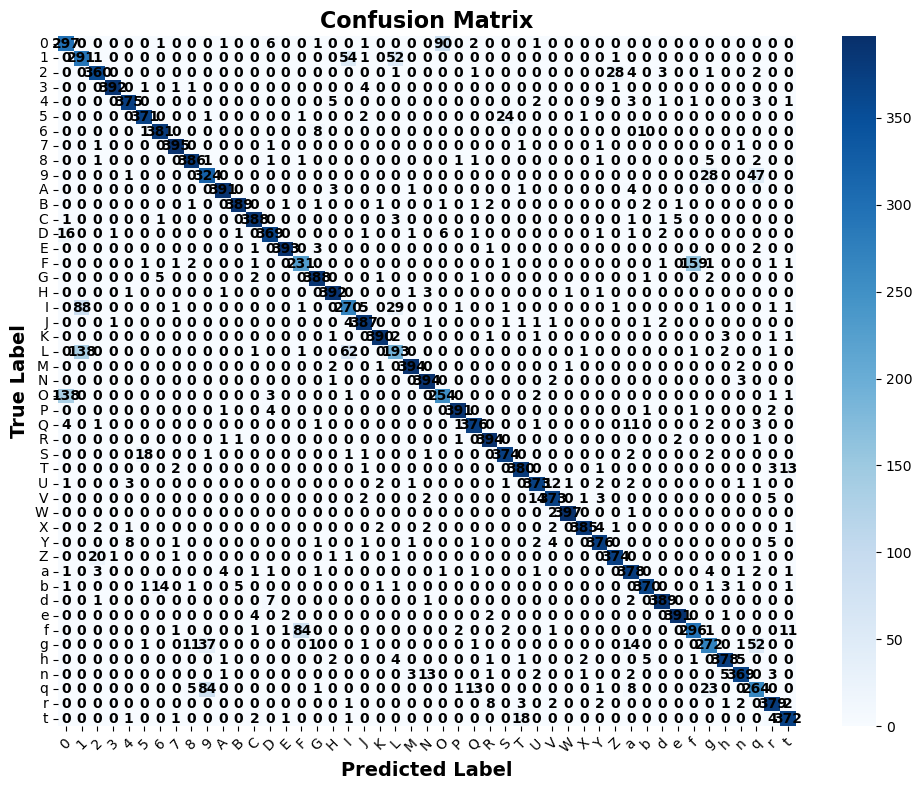

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Generate predictions and the true labels for the whole test set
def generate_confusion_matrix(model, test_loader):
    all_preds = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(emnist_mapping)))
    
    return cm

# Plot the confusion matrix using seaborn heatmap
def plot_confusion_matrix(cm, mapping):
    plt.figure(figsize=(10, 8))  # Smaller figure size for easier screenshot
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=mapping, yticklabels=mapping, 
                cbar=True, annot_kws={"size": 10, "weight": "bold", "color": "black"})
    
    # Formatting the plot
    plt.xlabel("Predicted Label", fontsize=14, weight='bold')
    plt.ylabel("True Label", fontsize=14, weight='bold')
    plt.title("Confusion Matrix", fontsize=16, weight='bold')
    
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Generate and plot confusion matrix
cm = generate_confusion_matrix(model, test_loader)
plot_confusion_matrix(cm, emnist_mapping)
